In [1]:
import dask
import xgboost
import dask_xgboost

from dask.distributed import Client
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### Train Model

In [2]:
# Initialize client
client = Client(n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:59742 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 12 Memory: 31.95 GiB


In [3]:
# Create 2D dask arrays with feature and target data

X, y = make_classification(
    n_samples=100000,
    n_features=20,
    chunks=1000,
    n_informative=4,
    random_state=0
)

X

dask.array<normal, shape=(100000, 20), dtype=float64, chunksize=(1000, 20), chunktype=numpy.ndarray>

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=6)
X_train

dask.array<concatenate, shape=(85000, 20), dtype=float64, chunksize=(850, 20), chunktype=numpy.ndarray>

In [7]:
params = {
    'objective':'binary:logistic',
    'max_depth':4,
    'eta': 0.01,
    'subsample': 0.5,
    'min_child_weight': 0.5
}

# train xgboost using dask
bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=10)

In [8]:
bst

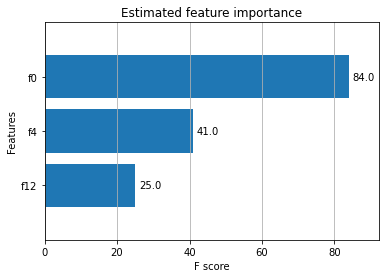

In [9]:
ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title("Estimated feature importance")
plt.show()

### Predict Results

In [10]:
# predict on testing data, then persist the lazy Dask array into memeory
y_hat = dask_xgboost.predict(client, bst, X_test).persist()
y_hat

[09:50:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1264: Empty dataset at worker: 0


dask.array<_predict_part, shape=(15000,), dtype=float32, chunksize=(150,), chunktype=numpy.ndarray>

In [12]:
y_truth, y_predict = dask.compute(y_test, y_hat)
fpr, tpr, _ = roc_curve(y_truth, y_predict)

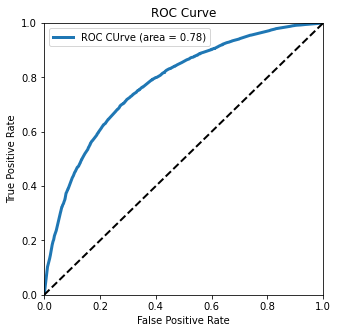

In [13]:
fig, ax = plt.subplots(figsize=(5,5,))
ax.plot(fpr, tpr, lw=3, label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))

ax.plot([0,1], [0,1], 'k--', lw=2)

ax.set(
    xlim=(0,1),
    ylim=(0,1),
    title='ROC Curve',
    xlabel='False Positive Rate',
    ylabel='True Positive Rate'
)

ax.legend()
plt.show()

### Shutdown

In [14]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
